In [1]:
import pandas as pd
import numpy as np
import sklearn
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, Ridge
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

## Load data

In [2]:
df = pd.read_csv('../data/fairlymade_products_impacts.csv')

## Drop product_types with too few items

In [3]:
threshold = 20
n_instances_before_dropping = len(df)

all_product_types = df['product_type'].unique()

product_type_count = df['product_type'].value_counts()
product_types_to_drop = product_type_count[product_type_count < threshold].index

df = df[~df['product_type'].isin(product_types_to_drop)]

print(f"Dropping {len(product_types_to_drop)} out of {len(product_type_count)} product_types because they have less then {threshold} items")
print(f"Percentage of instances dropped {round(100*(n_instances_before_dropping-len(df))/len(df), 2)}%")

Dropping 4 out of 34 product_types because they have less then 20 items
Percentage of instances dropped 0.38%


## Split the data

In [4]:
drop_columns = ['study_id', 'resource_use_fossils']
target = ['climate_change']
drop_columns.extend(target)

train, test = train_test_split(df, test_size=0.3, stratify=df['product_type'], random_state=0)
test, val = train_test_split(test, test_size=0.5, stratify=test['product_type'], random_state=0)

X_train, y_train = train.drop(columns=drop_columns), train[target].values.ravel()
X_val, y_val = val.drop(columns=drop_columns), val[target].values.ravel()
X_test, y_test = test.drop(columns=drop_columns), test[target].values.ravel()

In [5]:
print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"X_val: {len(X_val)}, y_val: {len(y_val)}")
print(f"X_test: {len(X_test)}, y_test: {len(y_test)}")

X_train: 6219, y_train: 6219
X_val: 1333, y_val: 1333
X_test: 1333, y_test: 1333


## Preprocessing pipeline

In [6]:
def convert_col_to_string(df, cols=['product_type', 'composition', 'raw_material_country', 
                                'weaving_country', 'dyeing_country', 'manufacturing_country']):
    for col in cols:
        df[col] = df[col].astype(str)
    return df

In [7]:
def generate_preprocessing_transformer():
    preprocessing_transformer = make_column_transformer(
        (OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=10, sparse_output=False), ['product_type']),
        (OneHotEncoder(drop='if_binary'), ['plane_in_transports']),
            (CountVectorizer(strip_accents='ascii'), 'raw_material_country'),
        (CountVectorizer(strip_accents='ascii'), 'weaving_country'),
        (CountVectorizer(strip_accents='ascii'), 'dyeing_country'),
        (CountVectorizer(strip_accents='ascii'), 'manufacturing_country'),
        (CountVectorizer(strip_accents='ascii'), 'composition'),
        remainder='drop'
    )

    return preprocessing_transformer

In [8]:
preprocessing_pipeline =  Pipeline([
        ('preprocessing', generate_preprocessing_transformer()),
    ])

In [9]:
X_train = convert_col_to_string(X_train)
X_val = convert_col_to_string(X_val)
X_test = convert_col_to_string(X_test)

In [10]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

In [11]:
X_train_preprocessed

<6219x283 sparse matrix of type '<class 'numpy.float64'>'
	with 48610 stored elements in Compressed Sparse Row format>

## Train the model

In [12]:
models_list = {
               'Ridge': Ridge(),
               'DecisionTree Regressor': DecisionTreeRegressor(),
               'Random Forest': RandomForestRegressor(), 
               'SVR': SVR(), 
               'XGBRegressor': XGBRegressor(),
               'Lasso': Lasso(),
               'KernelRidge': KernelRidge(),
               'ElasticNet': ElasticNet(),
               'GradientBoostingRegressor': GradientBoostingRegressor()
              }

scoring = {'max_error': 'max_error', 'neg_mean_squared_error': 'neg_mean_squared_error', 'r2':'r2'}
columns = ['Model', 'Median fit time', 'Mean max error', 'Std max error', 'RMSE', 'Std RMSE', 'Mean r2', 'Std r2']

folds = KFold(n_splits=5, shuffle=True, random_state=0)

In [13]:
X = X_train
y = y_train

model_perf_matrix = []
predictions = pd.DataFrame()
for model_name, model in tqdm(models_list.items()):
    pipeline = Pipeline([ 
        ('preprocessing', generate_preprocessing_transformer()),
        ('model', model)
    ])

    cv_score = cross_validate(pipeline, X, y, cv=folds, scoring=scoring, verbose=0, error_score="raise");
    model_perf_matrix.append([model_name, round(cv_score['fit_time'].mean(),3),
                                          round(cv_score['test_max_error'].mean(),4), round(cv_score['test_max_error'].std(),4),
                                          round(np.sqrt(-cv_score['test_neg_mean_squared_error']).mean(),4), round(np.sqrt(-cv_score['test_neg_mean_squared_error']).std(),4),
                                          round(cv_score['test_r2'].mean(),4), round(cv_score['test_r2'].std(),4)])
    
    pipeline.fit(X, y)
    predictions[model_name] = pipeline.predict(X_val).T
    
df_model_perf = pd.DataFrame(model_perf_matrix, columns=columns)
df_model_perf

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:10<00:00,  7.86s/it]


,Model,Median fit time,Mean max error,Std max error,RMSE,Std RMSE,Mean r2,Std r2
0,Ridge,0.087,-295.7801,63.0386,24.0353,1.8936,0.5449,0.0252
1,DecisionTree Regressor,0.175,-281.2839,83.6131,19.5178,1.3655,0.6969,0.0444
2,Random Forest,6.961,-259.3757,99.2717,18.1763,1.4038,0.7384,0.0307
3,SVR,1.373,-384.3536,69.3971,29.5060,2.3774,0.3148,0.0280
4,XGBRegressor,0.138,-259.8580,89.5692,18.2589,1.4465,0.7350,0.0389
5,Lasso,0.078,-346.3192,69.1519,27.2046,2.1204,0.4170,0.0300
6,KernelRidge,1.381,-296.1295,62.8524,24.0459,1.8976,0.5445,0.0252
7,ElasticNet,0.078,-389.7138,67.4950,32.1388,2.2769,0.1864,0.0167
8,GradientBoostingRegressor,0.252,-245.7965,99.7990,19.7911,1.4252,0.6914,0.0111


## Analyse predictions

In [14]:
predictions['label'] = y_val
predictions

,Ridge,DecisionTree Regressor,Random Forest,SVR,XGBRegressor,Lasso,KernelRidge,ElasticNet,GradientBoostingRegressor,label
0,13.470959,12.472909,13.193104,15.824836,12.175664,5.956887,14.177837,9.103895,19.735030,12.178119
1,62.748462,78.443715,77.657588,32.861656,77.888763,77.128668,62.633539,35.619234,53.012212,91.948182
2,0.410560,6.984949,6.858408,6.339246,5.273140,13.900364,0.292950,17.611345,7.428152,6.815810
3,26.157813,15.798639,16.308879,17.238265,19.032478,13.900364,25.951896,17.926515,20.231491,14.716049
4,16.982425,6.987076,6.498582,10.190521,7.796122,17.872102,16.286746,23.430663,12.391543,5.331121
...,...,...,...,...,...,...,...,...,...,...
1328,3.912336,4.345440,4.631292,9.069501,5.083318,17.872102,3.707318,22.858529,7.443683,4.341375
1329,3.735005,2.677243,3.083217,9.046104,6.757689,12.388404,2.779848,15.350309,6.923488,2.523200
1330,9.756810,10.816239,11.012681,11.612676,11.730863,13.900364,9.983479,19.342273,12.160687,11.788730
1331,33.594122,32.264075,32.123262,27.846688,28.045702,21.060438,33.367570,27.492851,24.968007,30.412119


In [15]:
for col in predictions.columns[0:-1]:
    print(f"val RMSE of {col}: {round(np.sqrt(mse(y_true=y_val, y_pred=predictions[col])), 6)}")

val RMSE of Ridge: 19.776891
val RMSE of DecisionTree Regressor: 21.64124
val RMSE of Random Forest: 17.189224
val RMSE of SVR: 24.408463
val RMSE of XGBRegressor: 18.022097
val RMSE of Lasso: 22.489828
val RMSE of KernelRidge: 19.807566
val RMSE of ElasticNet: 27.727013
val RMSE of GradientBoostingRegressor: 17.906411


### Regression plot

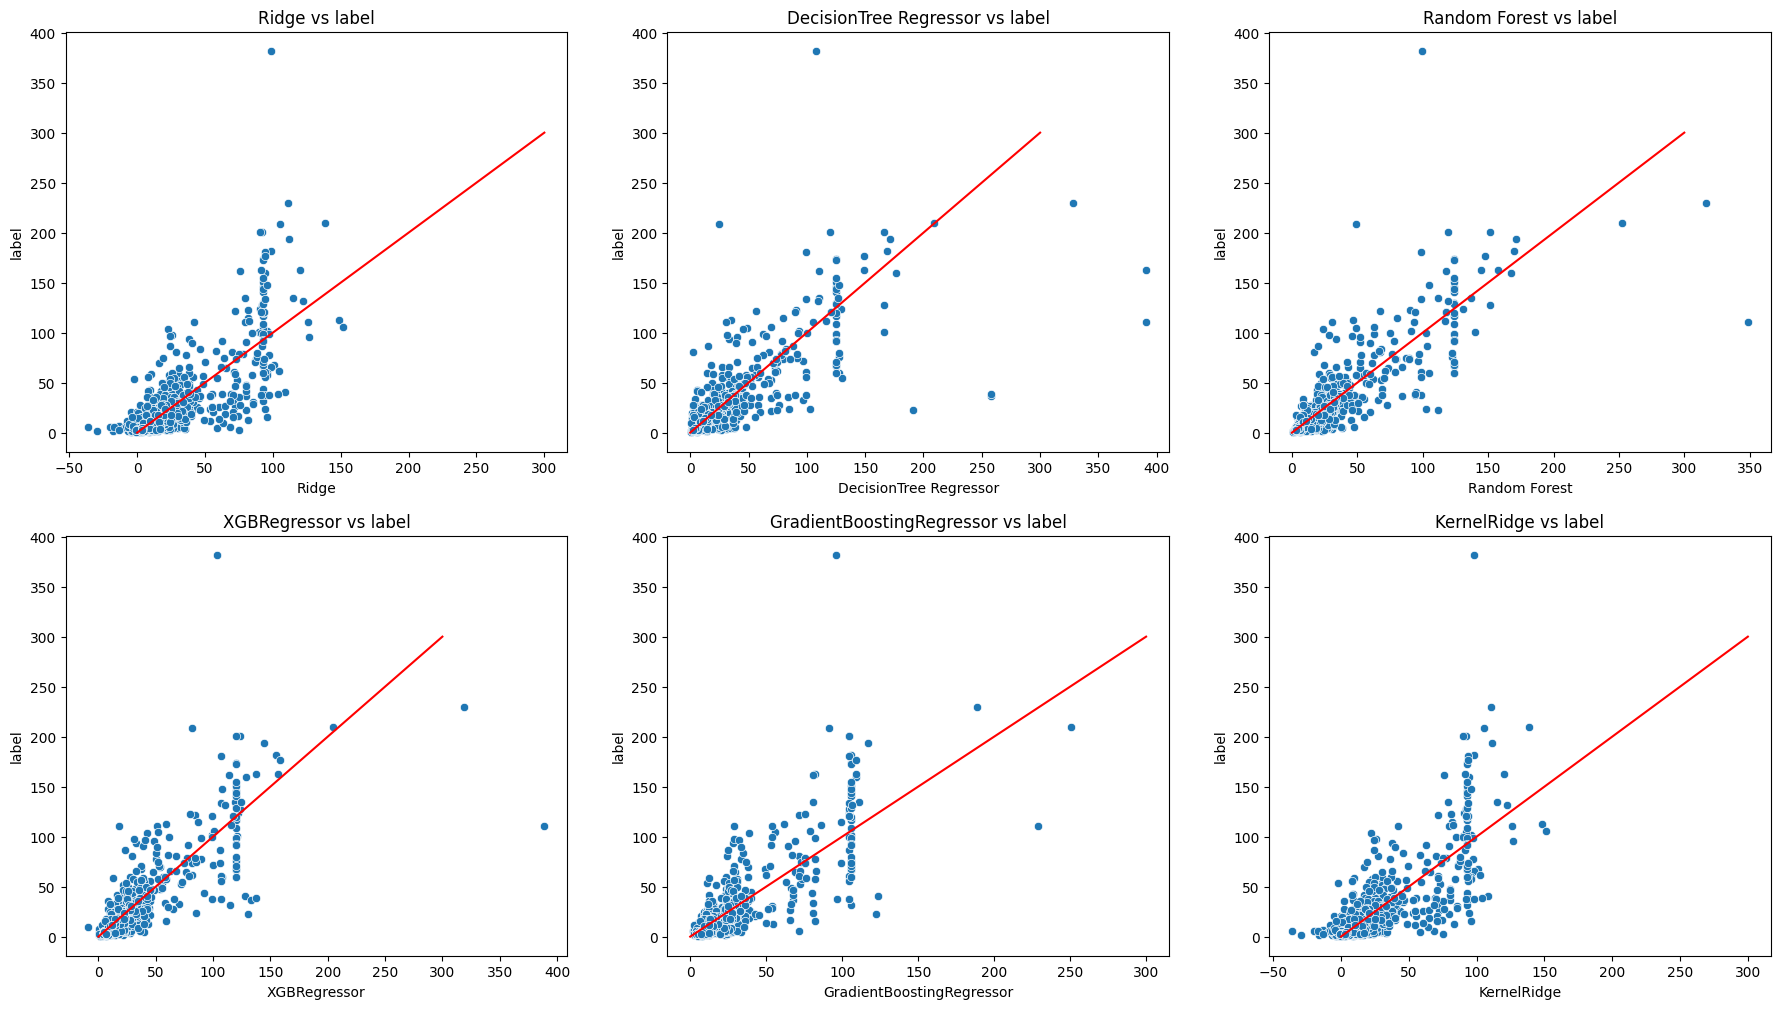

In [16]:
lim = 300

fig, ax = plt.subplots(2,3, figsize=(22,12))
sns.scatterplot(x="Ridge", y="label", data=predictions, ax=ax[0][0])
ax[0][0].set_title('Ridge vs label');
ax[0][0].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="DecisionTree Regressor", y="label", data=predictions, ax=ax[0][1])
ax[0][1].set_title('DecisionTree Regressor vs label');
ax[0][1].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="Random Forest", y="label", data=predictions, ax=ax[0][2])
ax[0][2].set_title('Random Forest vs label');
ax[0][2].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="XGBRegressor", y="label", data=predictions, ax=ax[1][0])
ax[1][0].set_title('XGBRegressor vs label');
ax[1][0].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="GradientBoostingRegressor", y="label", data=predictions, ax=ax[1][1])
ax[1][1].set_title('GradientBoostingRegressor vs label');
ax[1][1].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="KernelRidge", y='label', data=predictions, ax=ax[1][2])
ax[1][2].set_title('KernelRidge vs label');
ax[1][2].plot([0, lim], [0, lim], c = "red")

### How close are the predictions?

In [17]:
df_results = predictions[['XGBRegressor', 'label']]
df_results.loc[df_results['XGBRegressor'] < 1, 'XGBRegressor'] = 1
df_results['xgb_low'] = df_results['XGBRegressor'] * 0.8
df_results['xgb_high'] = df_results['XGBRegressor'] * 1.2
df_results['correct'] = (df_results['label'] > df_results['xgb_low']) & (df_results['label'] < df_results['xgb_high'])
df_results['correct'] = df_results['correct'].astype(int)
df_results.describe()

/tmp/ipykernel_68786/2380062351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['xgb_low'] = df_results['XGBRegressor'] * 0.8
/tmp/ipykernel_68786/2380062351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['xgb_high'] = df_results['XGBRegressor'] * 1.2
/tmp/ipykernel_68786/2380062351.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,XGBRegressor,label,xgb_low,xgb_high,correct
count,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000
mean,21.986670,21.944933,17.589336,26.384003,0.441110
std,29.738947,31.350334,23.791157,35.686737,0.496706
min,1.000000,0.778126,0.800000,1.200000,0.000000
25%,7.310199,5.836683,5.848159,8.772240,0.000000
50%,12.247436,11.988237,9.797949,14.696923,0.000000
75%,23.819000,23.742241,19.055201,28.582802,1.000000
max,388.909119,381.848120,311.127289,466.690948,1.000000


### Predictions visualization

/home/maxou1909/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxou1909/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


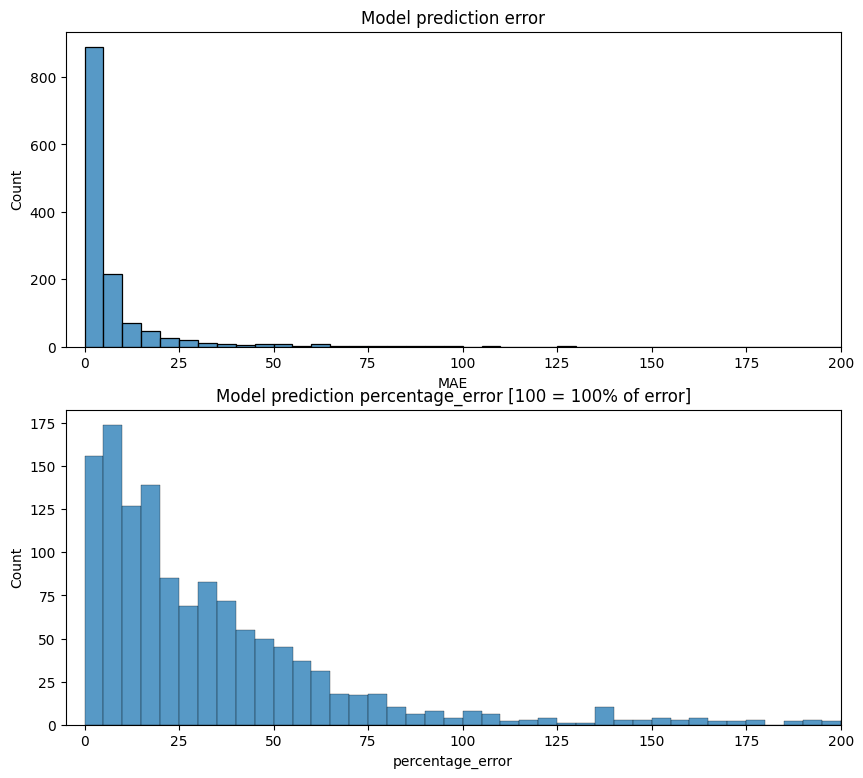

In [18]:
X_val = val.drop(columns=drop_columns)
predictions['MAE'] = np.abs(predictions['XGBRegressor'] - predictions['label'])
predictions['percentage_error'] = 100*predictions['MAE']/predictions['label']

fig, ax = plt.subplots(2,1, figsize=(10,9))
sns.histplot(data=predictions, x="MAE", ax=ax[0],binwidth=5)
ax[0].set_title('Model prediction error');
ax[0].set_xlim([-5, 200])

sns.histplot(data=predictions, x="percentage_error", ax=ax[1], binwidth=5)
ax[1].set_title('Model prediction percentage_error [100 = 100% of error]');
ax[1].set_xlim([-5, 200])
plt.show()

### Is there a difference in prediction performance depending on the product type?

In [19]:
X_val = val.drop(columns=drop_columns)
predictions['product_type'] = X_val['product_type'].values
predictions['percentage_error'] = np.abs(predictions['XGBRegressor'] - predictions['label'])/predictions['label']

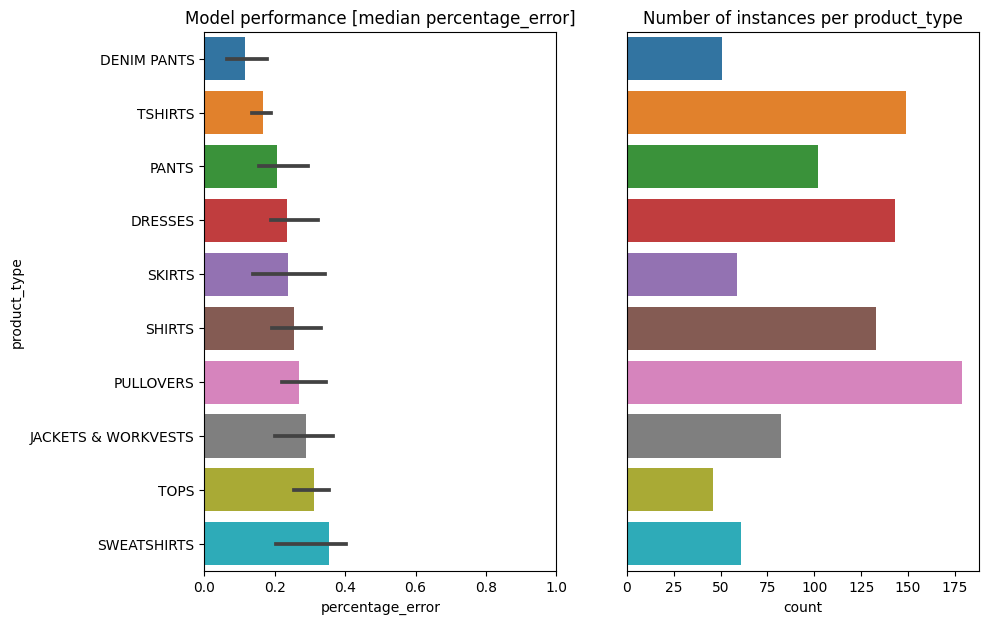

In [20]:
df = predictions.copy()
most_frequent_type = predictions['product_type'].value_counts()[0:10].index
df = df[df['product_type'].isin(most_frequent_type)]

order = df.groupby('product_type').agg({'percentage_error':'median'}).sort_values('percentage_error').index

fig, ax = plt.subplots(1,2, figsize=(10,7))
sns.barplot(data=df, y="product_type", x="percentage_error", estimator=np.median, order=order, errorbar='ci', ax=ax[0])
ax[0].set_title('Model performance [median percentage_error]');
ax[0].set_xlim([0, 1])

sns.countplot(data=df, y="product_type", order=order, ax=ax[1])
ax[1].set_title('Number of instances per product_type');
ax[1].set(ylabel=None)
ax[1].get_yaxis().set_visible(False)
plt.show()

### Is there a difference in prediction performance depending on the number of missing data?

In [21]:
X_val = val.drop(columns=drop_columns)
predictions['nb_missing_data'predictions['percentage_error'] = np.abs(predictions['XGBRegressor'] - predictions['label'])/predictions['label']] = X_val.isnull().sum(axis=1).values
predictions['MAE'] = np.abs(predictions['XGBRegressor'] - predictions['label'])
predictions['percentage_error'] = 100*predictions['MAE']/predictions['label']

SyntaxError: invalid syntax. Perhaps you forgot a comma? (268792178.py, line 2)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=predictions, x="nb_missing_data", y="MAE", estimator=np.median, errorbar='ci', ax=ax[0])
ax[0].set_title('Model performance [median MAE] vs missing data');

sns.countplot(data=predictions, x="nb_missing_data", ax=ax[1])
ax[1].set_title('Number of instances per missing data');
plt.show()